# **Data Generation using Modelling and Simulation for Machine Learning**
# Name: Sharon Abhishek Lal
# Roll Number: 102313037

# **Import all Libraries**

In [1]:
!pip install simpy

# **Defining Simulation Logic**

    Simulates a server queue.
    arrival_rate: Customers/packets per minute
    service_rate: Customers/packets processed per minute

In [3]:
import simpy
import random
import numpy as np
import pandas as pd

def server_simulation(env, arrival_rate, service_rate, results):
    driver = simpy.Resource(env, capacity=1)
    wait_times = []

    def packet_generator(env, arrival_rate, service_rate):
        i = 0
        while True:
            yield env.timeout(random.expovariate(arrival_rate))

            arrival_time = env.now

            with driver.request() as request:
                yield request

                service_duration = random.expovariate(service_rate)
                yield env.timeout(service_duration)

                wait_times.append(env.now - arrival_time)

    env.process(packet_generator(env, arrival_rate, service_rate))
    env.run(until=100)

    if wait_times:
        return np.mean(wait_times)
    return 0

# **Defining Parameters & Bounds**
    Arrival Rate [0.5, 5.0]
    Service Rate [5.0, 10.0]

In [4]:
data = []
n_simulations = 1000

print(f"Starting {n_simulations} simulations...")

for _ in range(n_simulations):
    arr_rate = random.uniform(0.5, 4.5)
    svc_rate = random.uniform(5.0, 10.0)

    env = simpy.Environment()

    avg_wait = server_simulation(env, arr_rate, svc_rate, data)

    data.append({
        "Arrival_Rate": arr_rate,
        "Service_Rate": svc_rate,
        "Avg_Wait_Time": avg_wait
    })

df = pd.DataFrame(data)
print("Data Generation Complete.")
df.head()

Starting 1000 simulations...
Data Generation Complete.


,Arrival_Rate,Service_Rate,Avg_Wait_Time
0,0.750742,6.507870,0.161004
1,3.911953,6.790759,0.132138
2,1.766864,5.461688,0.189564
3,3.455499,9.188973,0.098425
4,2.251657,7.151145,0.139603


# **Modelling**

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    explained_variance_score,
    max_error
)

X = df[['Arrival_Rate', 'Service_Rate']]
y = df['Avg_Wait_Time']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet": ElasticNet(),
    "Huber Regressor": HuberRegressor(),

    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),

    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Extra Trees": ExtraTreesRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor()
}

results = []
print(f"Training {len(models)} models...")
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, predictions)
        evs = explained_variance_score(y_test, predictions)
        max_err = max_error(y_test, predictions)

        results.append({
            "Model": name,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2 Score": r2,
            "Expl. Variance": evs,
            "Max Error": max_err
        })
    except Exception as e:
        print(f"Error training {name}: {e}")

results_df = pd.DataFrame(results)

results_df

Training 12 models...


,Model,MAE,MSE,RMSE,R2 Score,Expl. Variance,Max Error
0,Linear Regression,0.009791,0.000152,0.012345,0.834287,8.347071e-01,0.034452
1,Ridge Regression,0.009787,0.000152,0.012340,0.834412,8.348311e-01,0.034493
2,Lasso Regression,0.025420,0.000920,0.030326,-0.000062,-2.220446e-16,0.071378
3,ElasticNet,0.025420,0.000920,0.030326,-0.000062,-2.220446e-16,0.071378
4,Huber Regressor,0.009730,0.000151,0.012288,0.835819,8.364627e-01,0.035315
5,SVR,0.031871,0.001332,0.036498,-0.448511,-2.220446e-16,0.069248
6,KNN,0.009513,0.000160,0.012647,0.826063,8.270344e-01,0.048816
7,Decision Tree,0.012697,0.000272,0.016497,0.704074,7.043432e-01,0.065213
8,Random Forest,0.009761,0.000165,0.012858,0.820224,8.211470e-01,0.054889
9,Extra Trees,0.010012,0.000183,0.013539,0.800662,8.010391e-01,0.063766


# **Define Topsis for Ranking Models**

In [6]:
def apply_topsis(df):
    criteria_data = df.iloc[:, 1:].values

    weights = [0.10, 0.10, 0.25, 0.30, 0.10, 0.15]
    impacts = ['-', '-', '-', '+', '+', '-']

    norm_factor = np.sqrt((criteria_data**2).sum(axis=0))
    normalized_data = criteria_data / norm_factor

    weighted_data = normalized_data * weights

    ideal_best = []
    ideal_worst = []

    for i in range(len(impacts)):
        if impacts[i] == '+':
            ideal_best.append(max(weighted_data[:, i]))
            ideal_worst.append(min(weighted_data[:, i]))
        else:
            ideal_best.append(min(weighted_data[:, i]))
            ideal_worst.append(max(weighted_data[:, i]))

    dist_best = np.sqrt(((weighted_data - ideal_best)**2).sum(axis=1))
    dist_worst = np.sqrt(((weighted_data - ideal_worst)**2).sum(axis=1))

    topsis_score = dist_worst / (dist_best + dist_worst)

    return topsis_score

# **Applying to Results**

In [7]:
results_df['TOPSIS_Score'] = apply_topsis(results_df)

final_ranking = results_df.sort_values(by='TOPSIS_Score', ascending=False)

print("FINAL MODEL RANKING VIA TOPSIS:")
final_ranking

FINAL MODEL RANKING VIA TOPSIS:


,Model,MAE,MSE,RMSE,R2 Score,Expl. Variance,Max Error,TOPSIS_Score
4,Huber Regressor,0.009730,0.000151,0.012288,0.835819,8.364627e-01,0.035315,0.994653
1,Ridge Regression,0.009787,0.000152,0.012340,0.834412,8.348311e-01,0.034493,0.994465
0,Linear Regression,0.009791,0.000152,0.012345,0.834287,8.347071e-01,0.034452,0.994342
11,AdaBoost,0.009525,0.000148,0.012159,0.839225,8.392599e-01,0.040571,0.976244
6,KNN,0.009513,0.000160,0.012647,0.826063,8.270344e-01,0.048816,0.943923
10,Gradient Boosting,0.009451,0.000153,0.012383,0.833263,8.338267e-01,0.049811,0.941716
8,Random Forest,0.009761,0.000165,0.012858,0.820224,8.211470e-01,0.054889,0.921429
9,Extra Trees,0.010012,0.000183,0.013539,0.800662,8.010391e-01,0.063766,0.886771
7,Decision Tree,0.012697,0.000272,0.016497,0.704074,7.043432e-01,0.065213,0.832267
2,Lasso Regression,0.025420,0.000920,0.030326,-0.000062,-2.220446e-16,0.071378,0.314769


# **Visualisations through Plots**

/tmp/ipython-input-2764025970.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


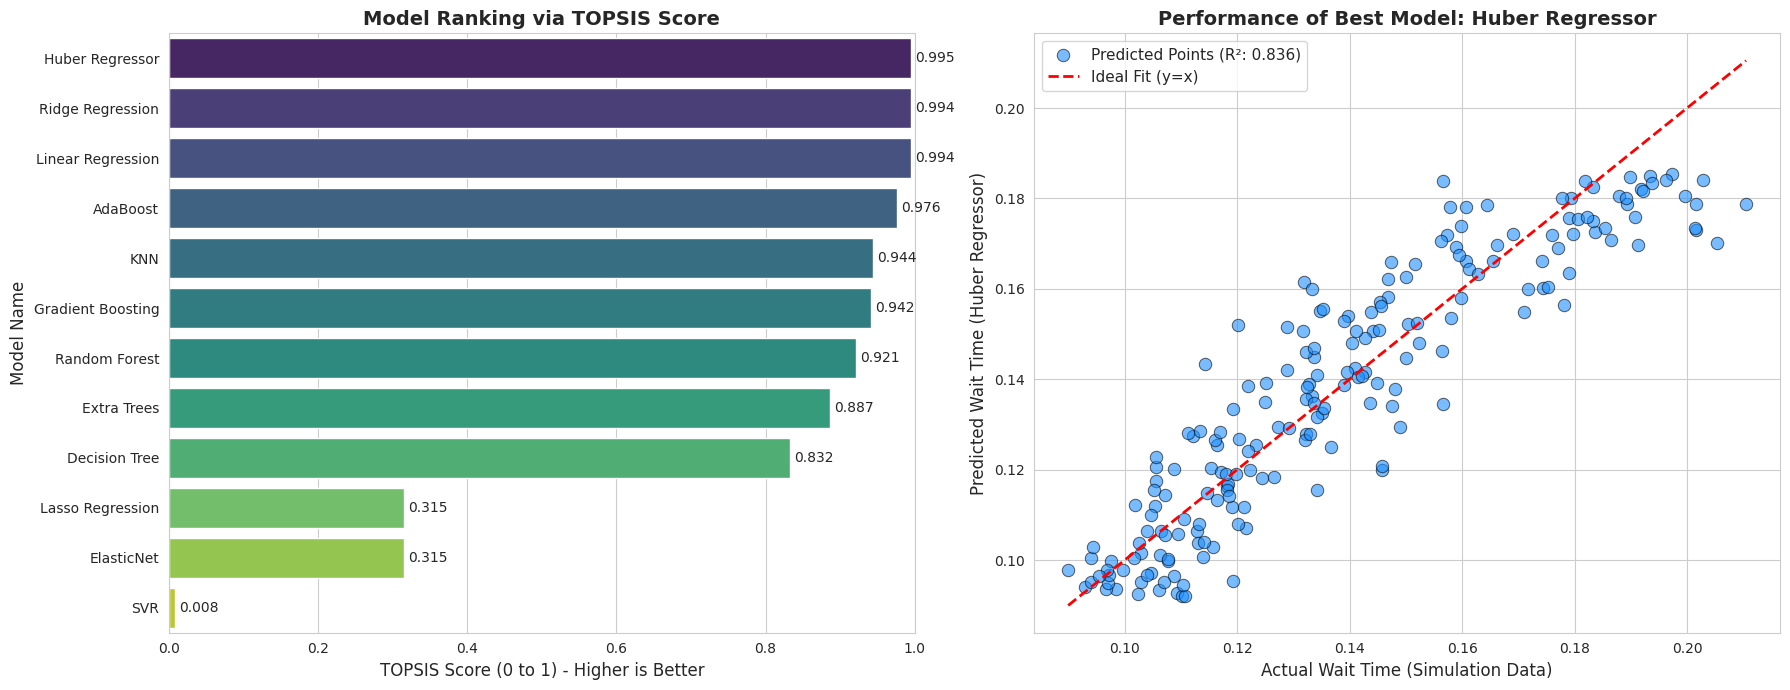

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# --- Graph 1: TOPSIS Ranking of All Models ---
sns.barplot(
    x="TOPSIS_Score",
    y="Model",
    data=final_ranking,
    palette="viridis",
    ax=ax1
)

ax1.set_title("Model Ranking via TOPSIS Score", fontsize=14, fontweight='bold')
ax1.set_xlabel("TOPSIS Score (0 to 1) - Higher is Better", fontsize=12)
ax1.set_ylabel("Model Name", fontsize=12)
ax1.set_xlim(0, 1.0)

for container in ax1.containers:
    ax1.bar_label(container, fmt='%.3f', padding=3, fontsize=10)


# --- Graph 2: Actual vs Predicted (Best Model Only) ---
best_model_name = final_ranking.iloc[0]["Model"]
best_topsis_score = final_ranking.iloc[0]["TOPSIS_Score"]
best_model = models[best_model_name]

# Generate predictions using this best model
y_pred_best = best_model.predict(X_test)

# Plot Scatter
sns.scatterplot(
    x=y_test,
    y=y_pred_best,
    alpha=0.6,
    color='dodgerblue',
    edgecolor='k',
    s=80,
    label=f"Predicted Points (R²: {final_ranking.iloc[0]['R2 Score']:.3f})",
    ax=ax2
)

# Plot the "Perfect Prediction" reference line (y=x)
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
ax2.plot(
    [min_val, max_val],
    [min_val, max_val],
    color='red',
    linestyle='--',
    linewidth=2,
    label="Ideal Fit (y=x)"
)

ax2.set_title(f"Performance of Best Model: {best_model_name}", fontsize=14, fontweight='bold')
ax2.set_xlabel("Actual Wait Time (Simulation Data)", fontsize=12)
ax2.set_ylabel(f"Predicted Wait Time ({best_model_name})", fontsize=12)
ax2.legend(loc='upper left', frameon=True, fontsize=11)

# Final Layout Adjustments
plt.tight_layout()
plt.show()